In [132]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
# from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
# import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



S:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
# conda install -c anaconda keras


In [134]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [135]:
# Combining all blocks
for num in range(0,112): # number of blocks in 112
    df = pd.read_csv("./daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("./intermediate/hc_"+str(num)+".csv")

fout= open("energy.csv","a")
# first file:
for line in open("./intermediate/hc_0.csv"):
    fout.write(line)
# now the rest:    
for num in range(0,112):
    f = open("./intermediate/hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

In [136]:
energy = pd.read_csv('energy.csv')
len(energy)

3536007

In [137]:
# The number of houses which reported the energy consumption on different days is different
# This might be due to loss of data or faulty smart meters
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount.head(10)

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41
2011-11-27,41
2011-11-28,55
2011-11-29,63
2011-11-30,76
2011-12-01,92


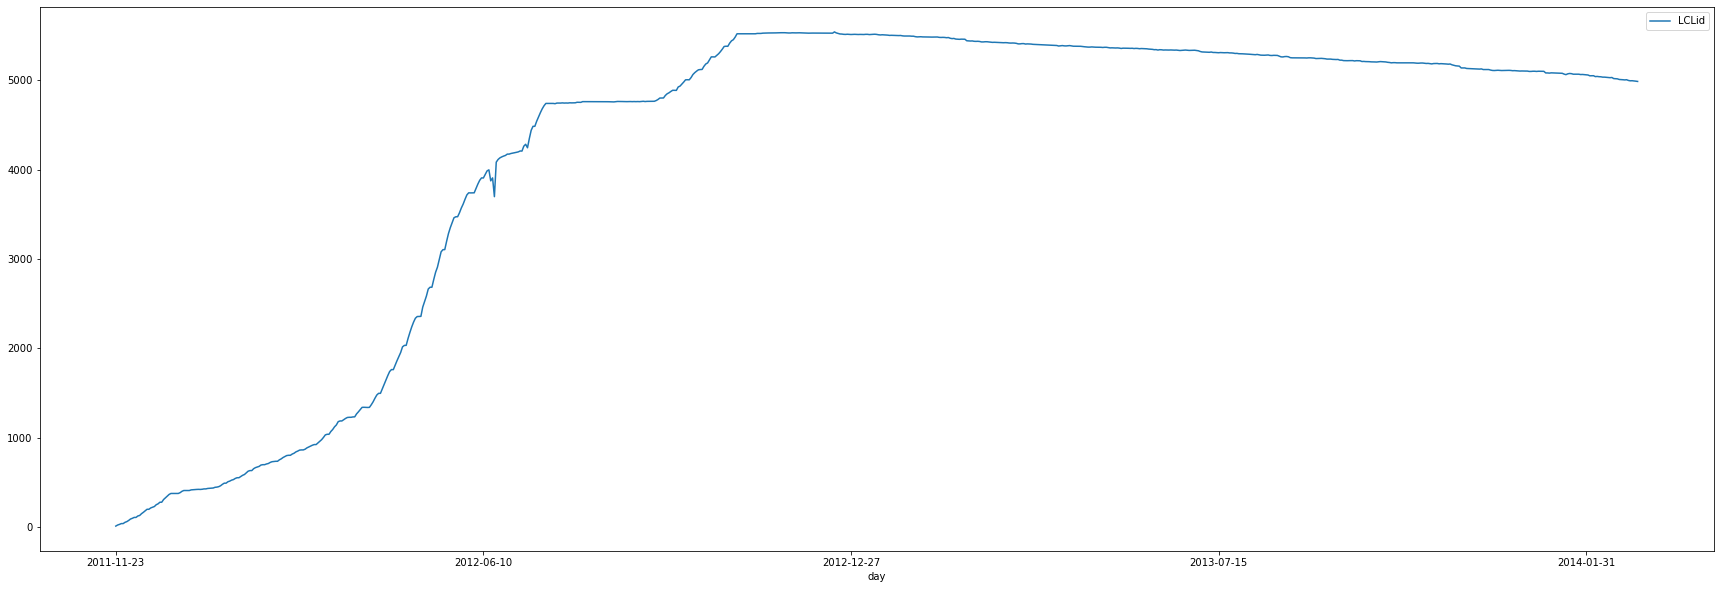

In [138]:
housecount.plot(figsize=(30,10))


In [139]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

In [140]:
energy.count()


day           829
energy_sum    829
LCLid         829
dtype: int64

In [141]:
energy

,day,energy_sum,LCLid
0,2011-11-23,90.385000,13
1,2011-11-24,213.412000,25
2,2011-11-25,303.993000,32
3,2011-11-26,420.976000,41
4,2011-11-27,444.883001,41
...,...,...,...
824,2014-02-24,52867.660004,4994
825,2014-02-25,52330.109999,4995
826,2014-02-26,51804.199995,4993
827,2014-02-27,52580.878999,4990


In [142]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date


In [143]:
energy

,day,energy_sum,LCLid
0,2011-11-23,90.385000,13
1,2011-11-24,213.412000,25
2,2011-11-25,303.993000,32
3,2011-11-26,420.976000,41
4,2011-11-27,444.883001,41
...,...,...,...
824,2014-02-24,52867.660004,4994
825,2014-02-25,52330.109999,4995
826,2014-02-26,51804.199995,4993
827,2014-02-27,52580.878999,4990


In [144]:
energy['LCLid']

0        13
1        25
2        32
3        41
4        41
       ... 
824    4994
825    4995
826    4993
827    4990
828    4987
Name: LCLid, Length: 829, dtype: int64

In [145]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']


In [146]:
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [147]:
energy.describe()


,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,43535.325676,4234.539204,10.491862
std,20550.594031,1789.994799,1.902513
min,90.385000,13.000000,0.211766
25%,34665.436003,4084.000000,8.676955
50%,46641.160997,5138.000000,10.516983
75%,59755.616996,5369.000000,12.000690
max,84156.135002,5541.000000,15.964434


In [148]:
weather = pd.read_csv('./weather_daily_darksky.csv')
weather.head(4)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25


In [149]:
weather.describe()


,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,13.660113,195.702948,6.530034,0.477605,3.581803,1014.127540,12.723866,11.167143,0.781871,6.085045,12.929467,2.542565,7.709841,7.414161,13.542392,5.738039,0.500930
std,6.182744,89.340783,4.830875,0.193514,1.694007,11.073038,7.279168,2.466109,0.095348,6.031967,7.105426,1.832985,4.871004,4.888852,6.260196,6.048746,0.287022
min,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,9.502500,120.500000,3.180000,0.350000,2.370000,1007.435000,7.032500,10.327500,0.720000,1.522500,7.332500,1.000000,3.990000,3.705000,9.212500,1.105000,0.260000
50%,12.625000,219.000000,6.380000,0.470000,3.440000,1014.615000,12.470000,11.970000,0.790000,5.315000,12.625000,2.000000,7.540000,7.100000,12.470000,4.885000,0.500000
75%,17.920000,255.000000,10.057500,0.600000,4.577500,1021.755000,17.910000,12.830000,0.860000,11.467500,17.920000,4.000000,11.467500,11.277500,17.910000,11.277500,0.750000
max,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


In [150]:
weather 
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

In [151]:
weather

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,day
0,11.96,123,9.40,0.79,3.88,1016.08,10.87,3.30,0.95,10.87,11.96,1.0,10.87,8.85,10.87,6.48,0.52,2011-11-11
1,8.59,198,4.49,0.56,3.94,1007.71,5.62,12.09,0.88,-0.64,5.72,1.0,3.09,2.48,8.59,0.11,0.53,2011-12-11
2,10.33,225,5.47,0.85,3.54,1032.76,10.33,13.39,0.74,5.52,10.33,0.0,8.03,8.03,10.33,5.59,0.10,2011-12-27
3,8.07,232,3.69,0.32,3.00,1012.12,5.33,11.89,0.87,3.26,5.33,1.0,6.33,2.56,7.36,0.46,0.25,2011-12-02
4,8.22,252,2.79,0.37,4.46,1028.17,5.02,13.16,0.80,4.37,5.32,1.0,7.45,3.17,7.93,-0.51,0.99,2011-12-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,9.03,233,2.39,0.40,4.55,1002.10,5.99,11.97,0.79,-2.02,5.99,1.0,2.56,3.26,9.03,-1.30,0.84,2014-01-26
878,10.31,224,3.08,0.32,4.14,1007.02,10.31,12.04,0.74,0.82,10.31,2.0,3.43,3.93,10.31,1.41,0.93,2014-02-27
879,18.97,172,4.30,0.04,2.78,1022.44,18.97,10.62,0.58,4.12,18.97,3.0,5.04,7.65,18.97,7.08,0.28,2014-03-09
880,8.83,210,1.94,0.59,7.24,994.27,4.73,11.80,0.75,0.05,4.73,1.0,4.14,3.03,8.83,-1.20,0.42,2014-02-12


In [152]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97


S:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
S:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
S:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
W0704 11:47:31.792435 17176 legend.py:1282] No handles with labels found to put in legend.
W0704 11:47:31.880201 17176 legend.py:1282] No handles with labels found to put 

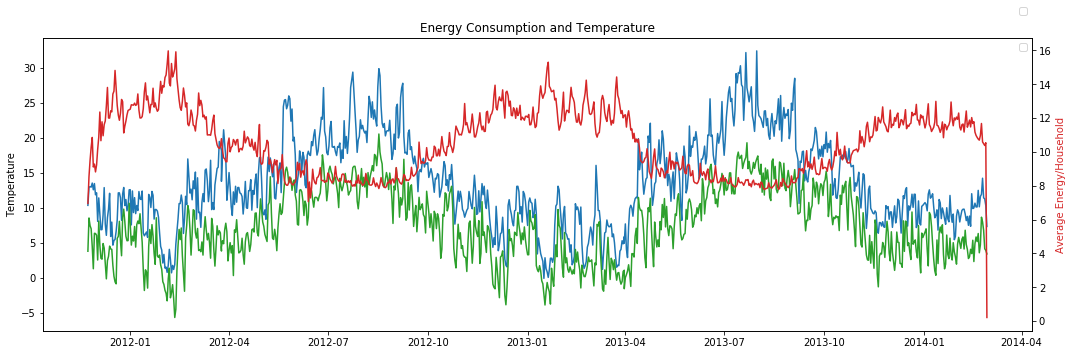

In [153]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:blue')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:green')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red')
ax2.set_ylabel('Average Energy/Household',color = 'tab:red')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

W0704 11:47:32.982774 17176 legend.py:1282] No handles with labels found to put in legend.
W0704 11:47:33.016338 17176 legend.py:1282] No handles with labels found to put in legend.


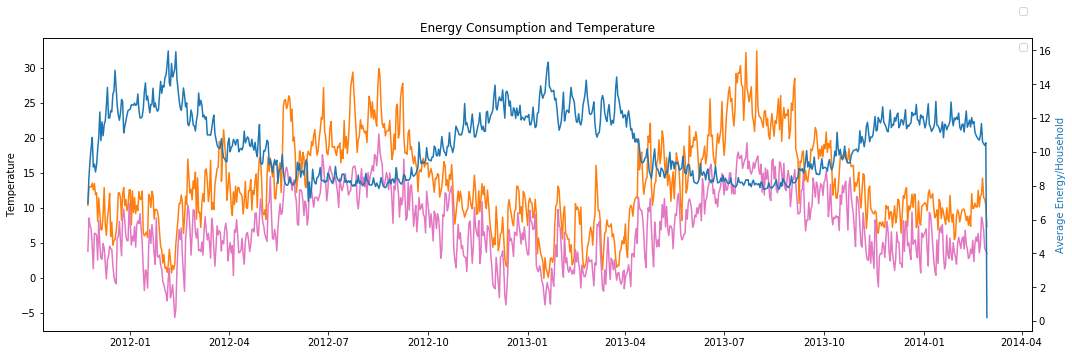

In [154]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

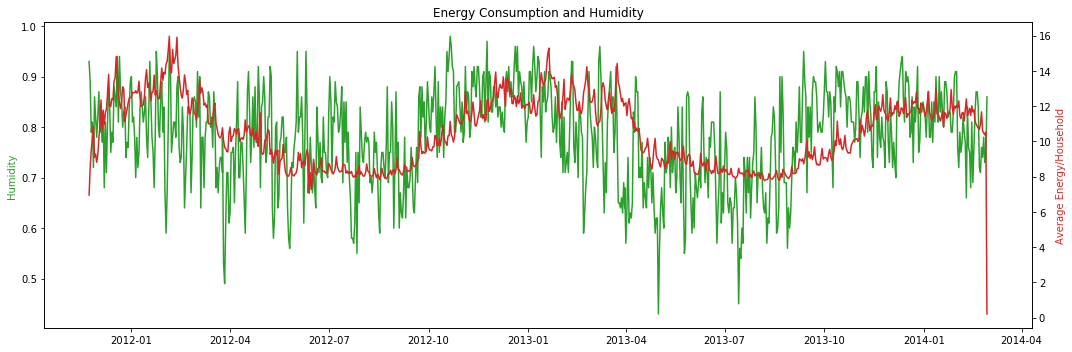

In [155]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:green')
ax1.set_ylabel('Humidity',color = 'tab:green')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red')
ax2.set_ylabel('Average Energy/Household',color = 'tab:red')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

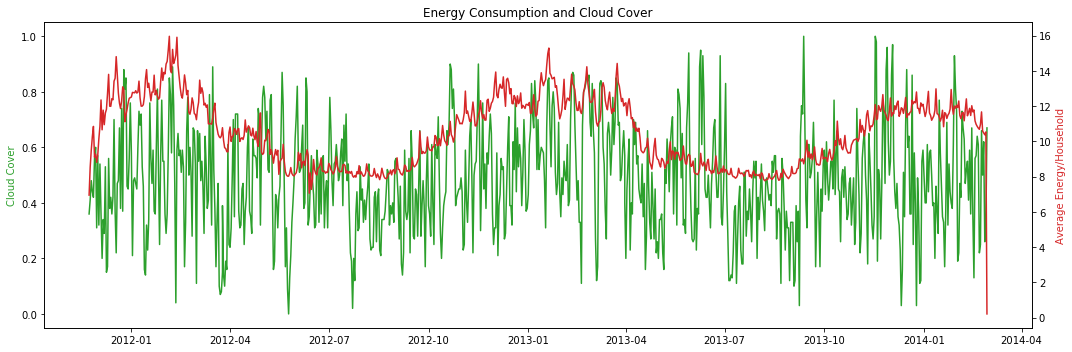

In [156]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:green')
ax1.set_ylabel('Cloud Cover',color = 'tab:green')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red')
ax2.set_ylabel('Average Energy/Household',color = 'tab:red')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

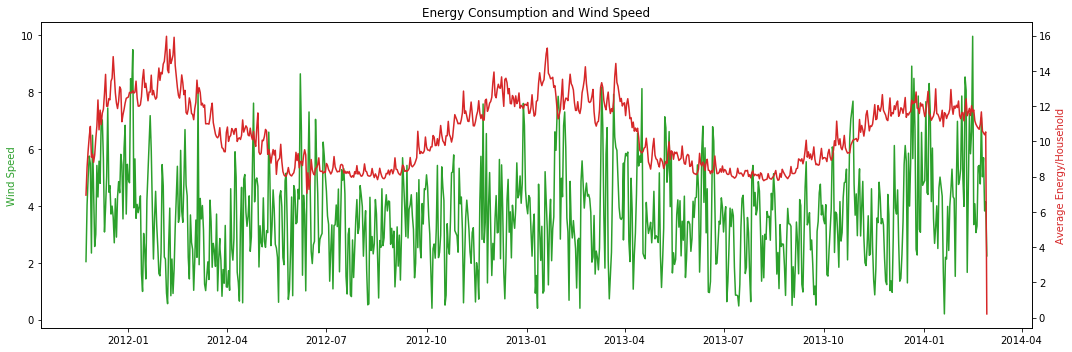

In [157]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:green')
ax1.set_ylabel('Wind Speed',color = 'tab:green')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red')
ax2.set_ylabel('Average Energy/Household',color = 'tab:red')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

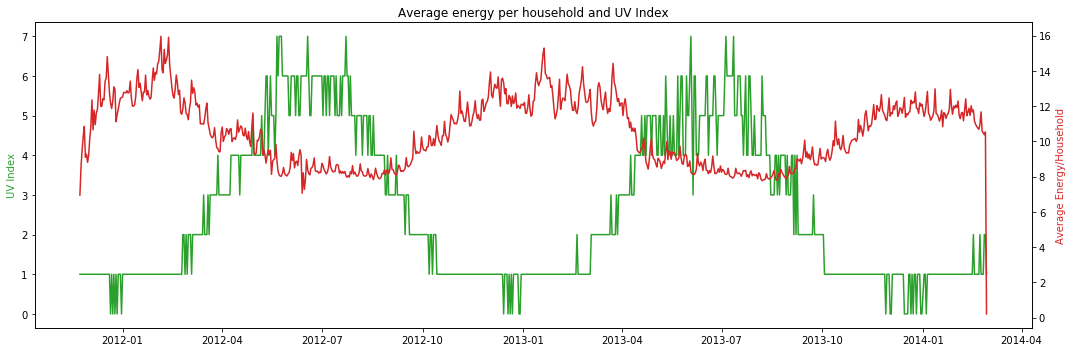

In [158]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:green')
ax1.set_ylabel('UV Index',color = 'tab:green')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red')
ax2.set_ylabel('Average Energy/Household',color = 'tab:red')
plt.title('Average energy per household and UV Index')
fig.tight_layout()
plt.show()

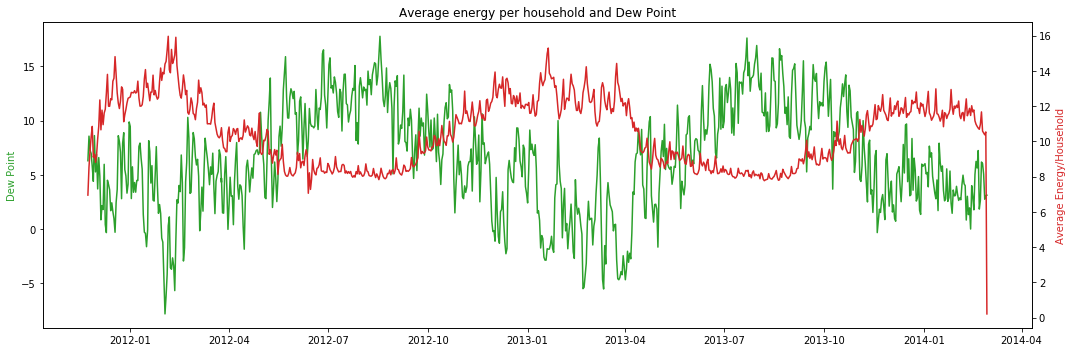

In [159]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:green')
ax1.set_ylabel('Dew Point',color = 'tab:green')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:red')
ax2.set_ylabel('Average Energy/Household',color = 'tab:red')
plt.title('Average energy per household and Dew Point')
fig.tight_layout()
plt.show()

In [160]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.846965,-0.755901,0.241779,0.149624,-0.028851,-0.246404,0.361237,-0.733171,-0.031716
temperatureMax,-0.846965,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.755901,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.241779,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.149624,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.028851,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.246404,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.361237,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.733171,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.031716,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


In [161]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

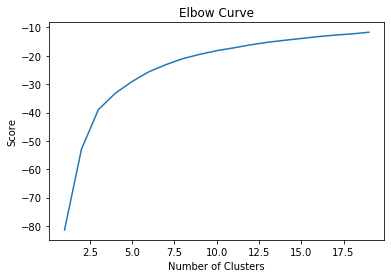

In [162]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [163]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

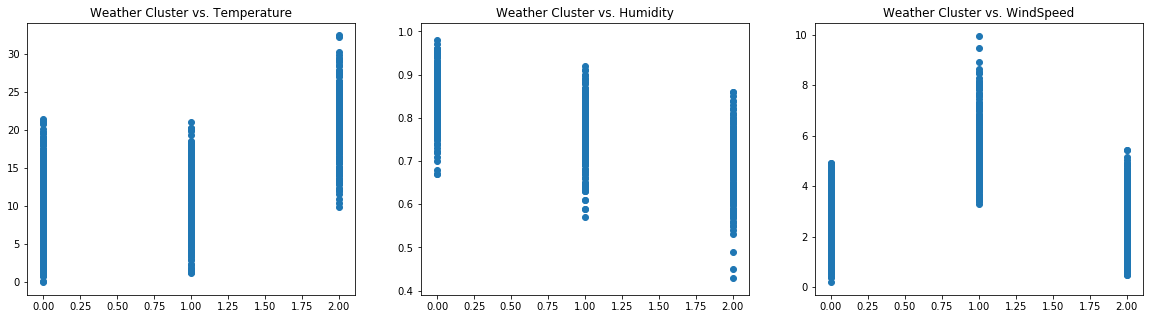

In [164]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()
# put this in a loop

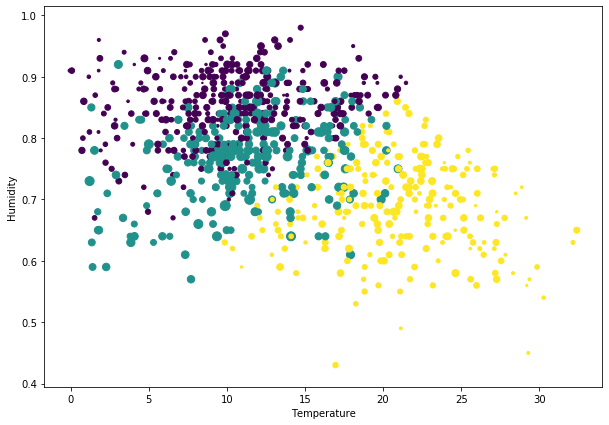

In [165]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax, 
            weather_energy.humidity, 
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

In [166]:
holiday = pd.read_csv('./uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head(4)

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)


In [167]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

In [168]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

In [169]:
model_data = weather_energy[['avg_energy','weather_cluster','holiday_ind']]
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

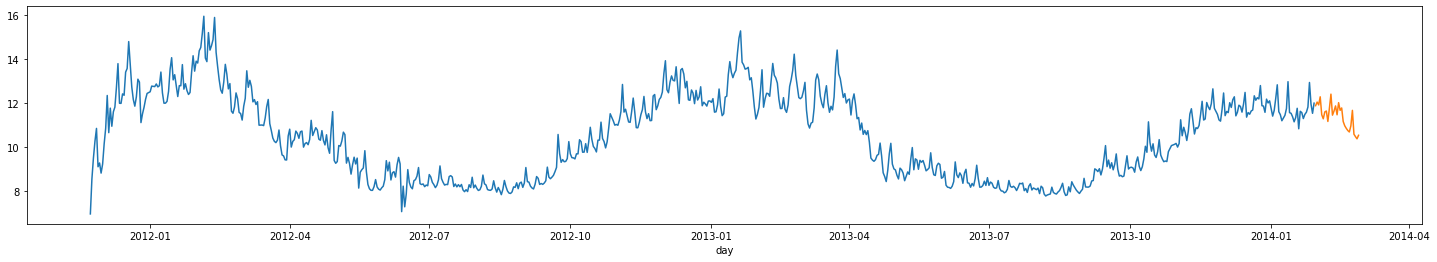

In [170]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))

In [171]:
test.head(1)


,avg_energy,weather_cluster,holiday_ind
day,,,
2014-01-30,11.886982,0,0


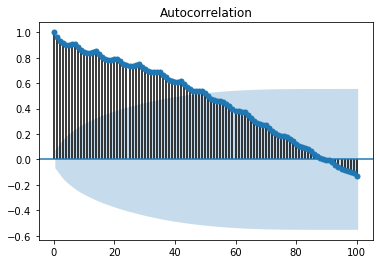

In [172]:
plot_acf(train.avg_energy,lags=100)
plt.show()

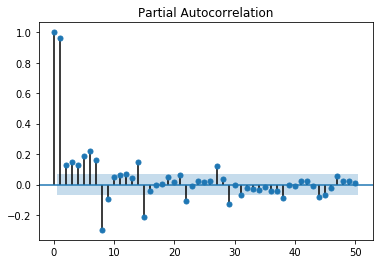

In [173]:
plot_pacf(train.avg_energy,lags=50)
plt.show()

In [174]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.872794
p-value                          0.344966
#Lags Used                      21.000000
Number of Observations Used    776.000000
dtype: float64

In [175]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [176]:
t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.715004e+00
p-value                        3.600554e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.760000e+02
dtype: float64

In [177]:
s = sm.tsa.seasonal_decompose(train.avg_energy,freq=12)


S:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


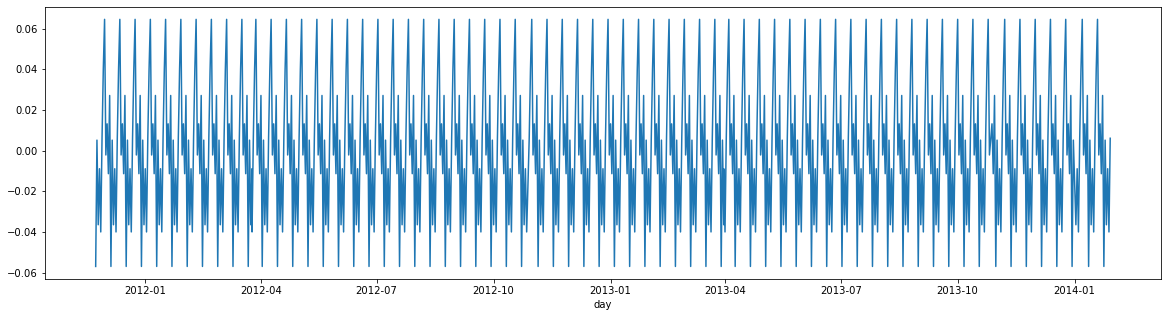

In [178]:
s.seasonal.plot(figsize=(20,5))


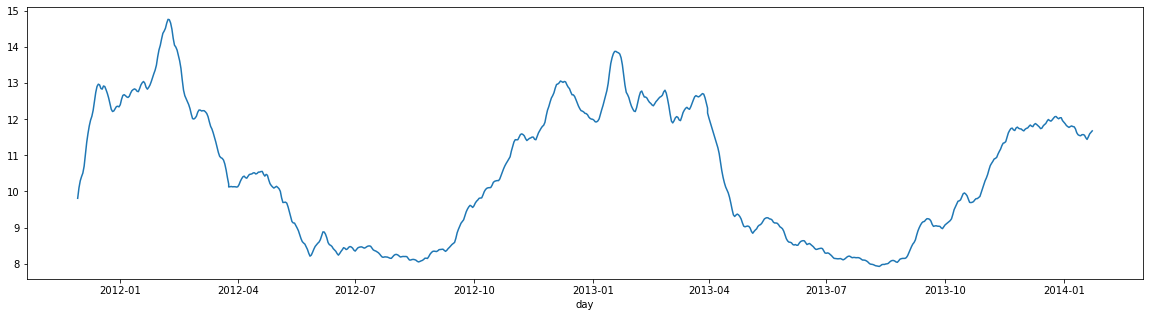

In [179]:
s.trend.plot(figsize=(20,5))


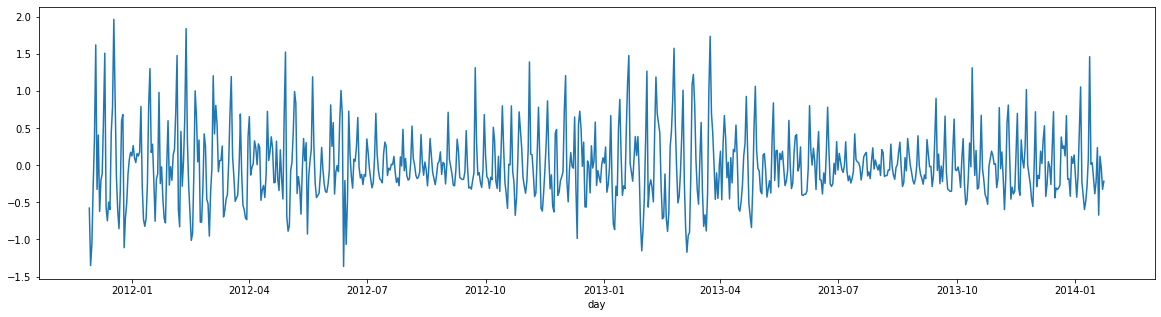

In [180]:
s.resid.plot(figsize=(20,5))


In [181]:
endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster','holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()

S:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
S:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 12)   Log Likelihood                -649.428
Date:                             Sun, 04 Jul 2021   AIC                           1326.856
Time:                                     11:48:38   BIC                           1392.176
Sample:                                          0   HQIC                          1351.971
                                             - 798                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.0065      0.017     -0.383      0.702      -0.040       0.027
const           -3.177e-08    8.3e-10    -38.282      0.000   -3.34e-08   -3.01e-08
weather_cluster     0.0008      0.024      0.034      0.973      -0.046       0.048
holiday_ind        -0.0343      0.088     -0.390      0.696      -0.207       0.138
ar.L1              -0.0007      0.086     -0.008      0.994      -0.170       0.168
ar.L2              -0.1548      0.032     -4.841      0.000      -0.217      -0.092
ar.L3              -0.1430      0.038     -3.747      0.000      -0.218      -0.068
ar.L4              -0.1512      0.038     -3.980      0.000      -0.226      -0.077
ar.L5              -0.1631      0.040     -4.077      0.000      -0.241      -0.085
ar.L6               0.0087      0.036      0.239      0.811      -0.062       0.080
ar.L7               0.3527      0.029     12.277      0.000       0.296       0.409
ma.L1              -0.1856      0.091     -2.037      0.042      -0.364      -0.007
ar.S.L12           -0.4830      0.032    -14.907      0.000      -0.547      -0.420
sigma2              0.3041      0.013     24.102      0.000       0.279       0.329
===================================================================================
Ljung-Box (Q):                      221.19   Jarque-Bera (JB):                45.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.28e+16. Standard errors may be unstable.
"""

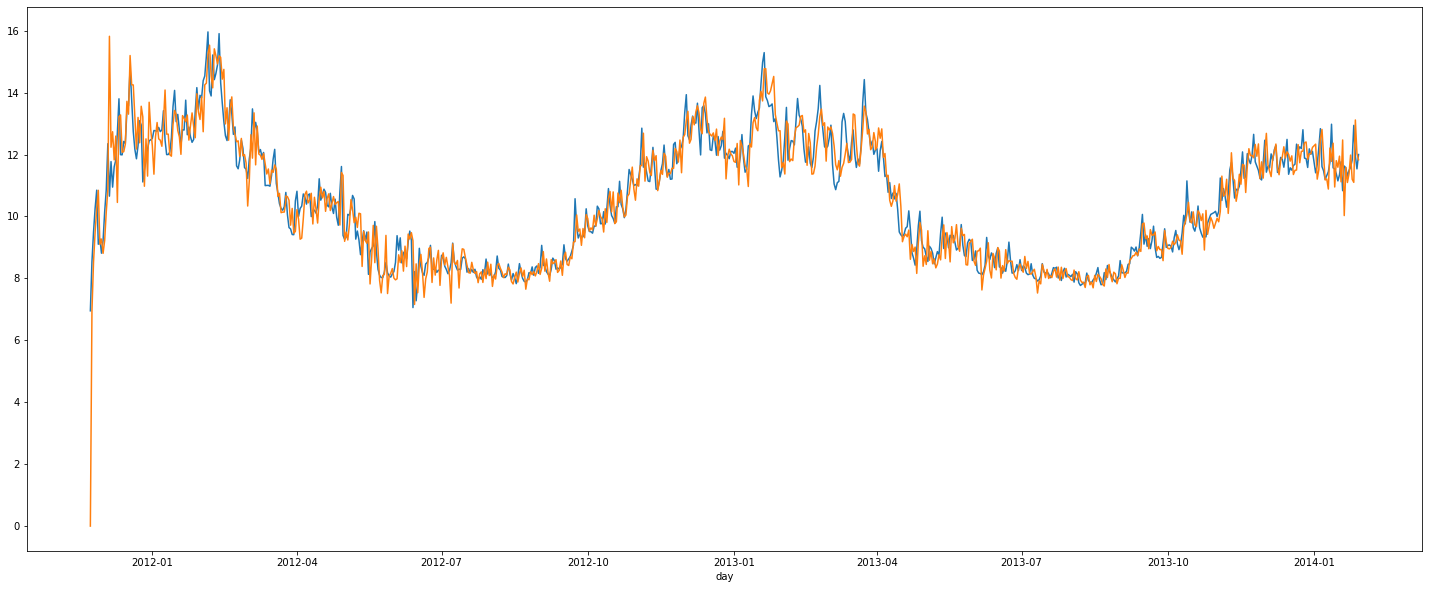

In [182]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [183]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster','holiday_ind']]))
test['predicted'] = predict.values
test.tail(10)

S:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
S:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,avg_energy,weather_cluster,holiday_ind,predicted
day,,,,
2014-02-18,10.971368,0,0,11.658190
2014-02-19,10.854245,0,0,12.372850
2014-02-20,10.754953,1,0,11.700947
2014-02-21,10.688234,1,0,11.498433
2014-02-22,10.970704,1,0,11.935139
2014-02-23,11.673756,1,0,11.556620
2014-02-24,10.586235,1,0,10.708420
2014-02-25,10.476498,1,0,11.446812
2014-02-26,10.375366,1,0,11.869617


In [184]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.5853433790381639
MAPE: 5.238944550644147


S:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


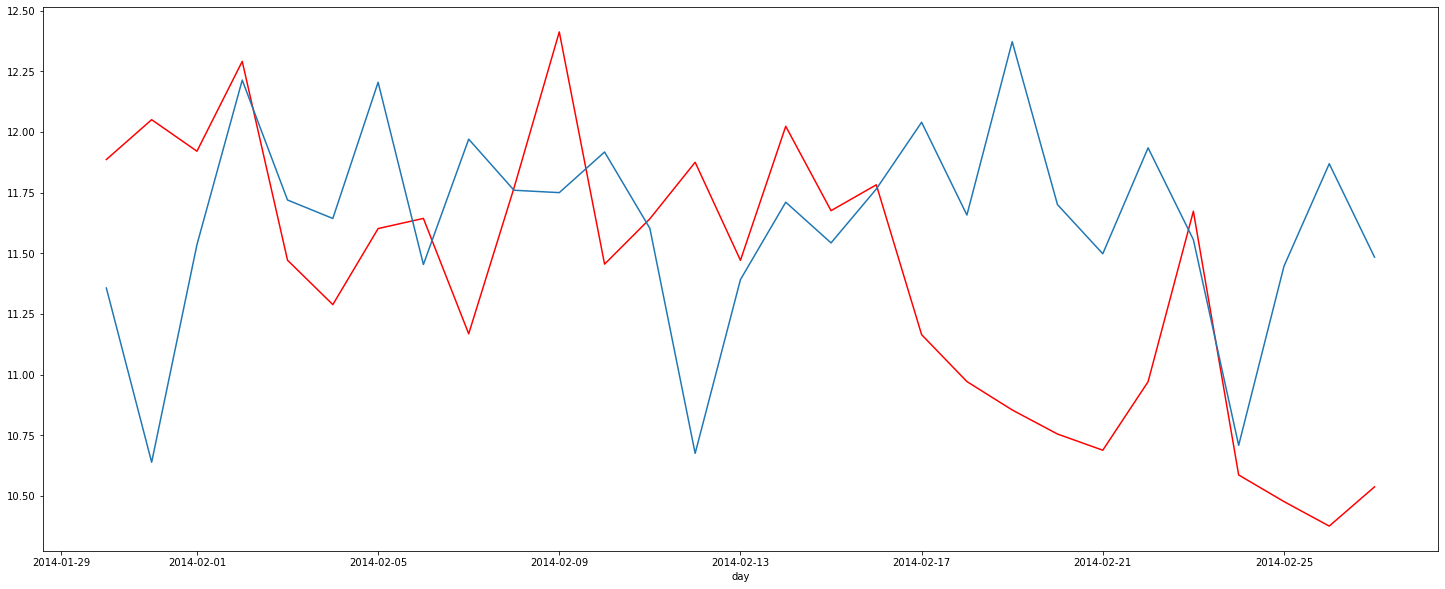

In [185]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

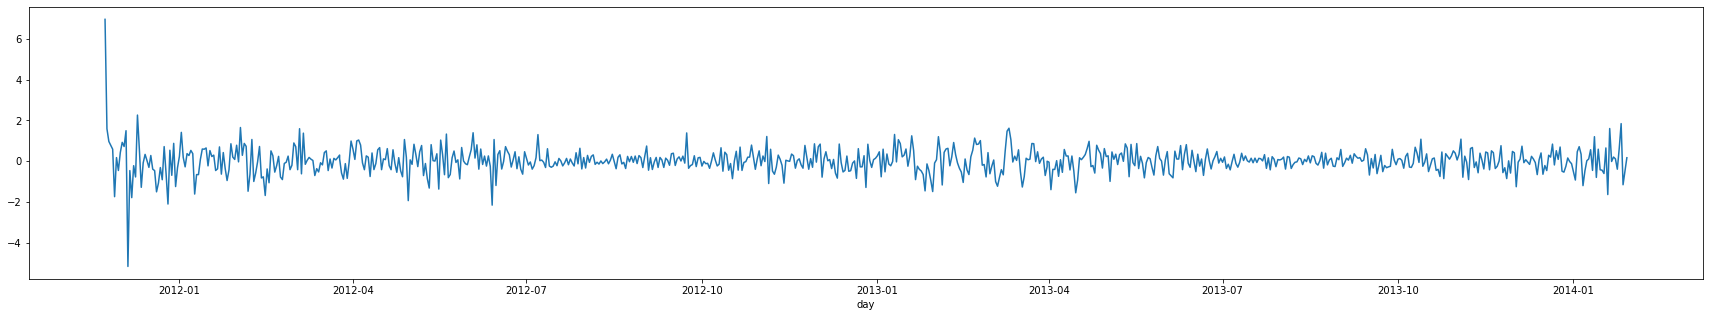

In [186]:
model_fit.resid.plot(figsize= (30,5))


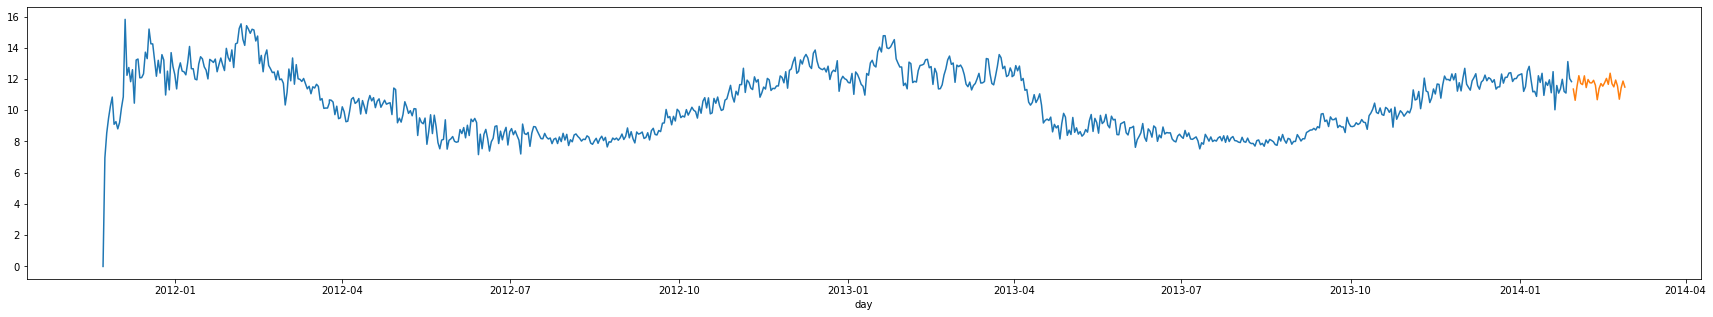

In [187]:
model_fit.fittedvalues.plot(figsize = (30,5))
test.predicted.plot()

In [188]:
test['predicted'].tail(5)


day
2014-02-23    11.556620
2014-02-24    10.708420
2014-02-25    11.446812
2014-02-26    11.869617
2014-02-27    11.484389
Name: predicted, dtype: float64

In [189]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [190]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [191]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(10)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910
10,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910,10.862155
11,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910,10.862155,12.351882
12,9.103382,9.274873,8.813513,9.227707,10.145910,10.862155,12.351882,10.657492
13,9.274873,8.813513,9.227707,10.145910,10.862155,12.351882,10.657492,11.774341
14,8.813513,9.227707,10.145910,10.862155,12.351882,10.657492,11.774341,10.948980
15,9.227707,10.145910,10.862155,12.351882,10.657492,11.774341,10.948980,11.606970
16,10.145910,10.862155,12.351882,10.657492,11.774341,10.948980,11.606970,11.824055


In [192]:
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]


In [193]:
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

In [194]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [195]:
# split into train and test sets
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]

In [196]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [197]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(791, 1, 9) (791,) (30, 1, 9) (30,)


Epoch 1/50
 - 2s - loss: 0.5432
Epoch 2/50
 - 0s - loss: 0.4215
Epoch 3/50
 - 0s - loss: 0.2876
Epoch 4/50
 - 0s - loss: 0.1394
Epoch 5/50
 - 0s - loss: 0.0791
Epoch 6/50
 - 0s - loss: 0.0840
Epoch 7/50
 - 0s - loss: 0.0736
Epoch 8/50
 - 0s - loss: 0.0692
Epoch 9/50
 - 0s - loss: 0.0660
Epoch 10/50
 - 0s - loss: 0.0640
Epoch 11/50
 - 0s - loss: 0.0614
Epoch 12/50
 - 0s - loss: 0.0589
Epoch 13/50
 - 0s - loss: 0.0567
Epoch 14/50
 - 0s - loss: 0.0543
Epoch 15/50
 - 0s - loss: 0.0521
Epoch 16/50
 - 0s - loss: 0.0497
Epoch 17/50
 - 0s - loss: 0.0475
Epoch 18/50
 - 0s - loss: 0.0453
Epoch 19/50
 - 0s - loss: 0.0432
Epoch 20/50
 - 0s - loss: 0.0411
Epoch 21/50
 - 0s - loss: 0.0392
Epoch 22/50
 - 0s - loss: 0.0373
Epoch 23/50
 - 0s - loss: 0.0356
Epoch 24/50
 - 0s - loss: 0.0339
Epoch 25/50
 - 0s - loss: 0.0323
Epoch 26/50
 - 0s - loss: 0.0308
Epoch 27/50
 - 0s - loss: 0.0295
Epoch 28/50
 - 0s - loss: 0.0282
Epoch 29/50
 - 0s - loss: 0.0272
Epoch 30/50
 - 0s - loss: 0.0264
Epoch 31/50
 - 0s -

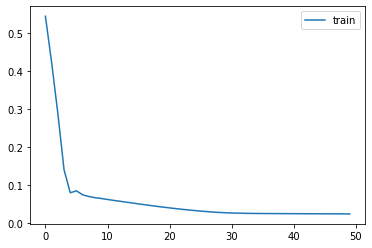

In [198]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [199]:
# make a prediction
yhat = model.predict(test_X)

In [200]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])


In [201]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [202]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [203]:
act = [i[0] for i in inv_y] # first element is the predicted average energy WRONG
pred = [i[0] for i in inv_yhat] # first element is the actual average energy WRONG

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.249


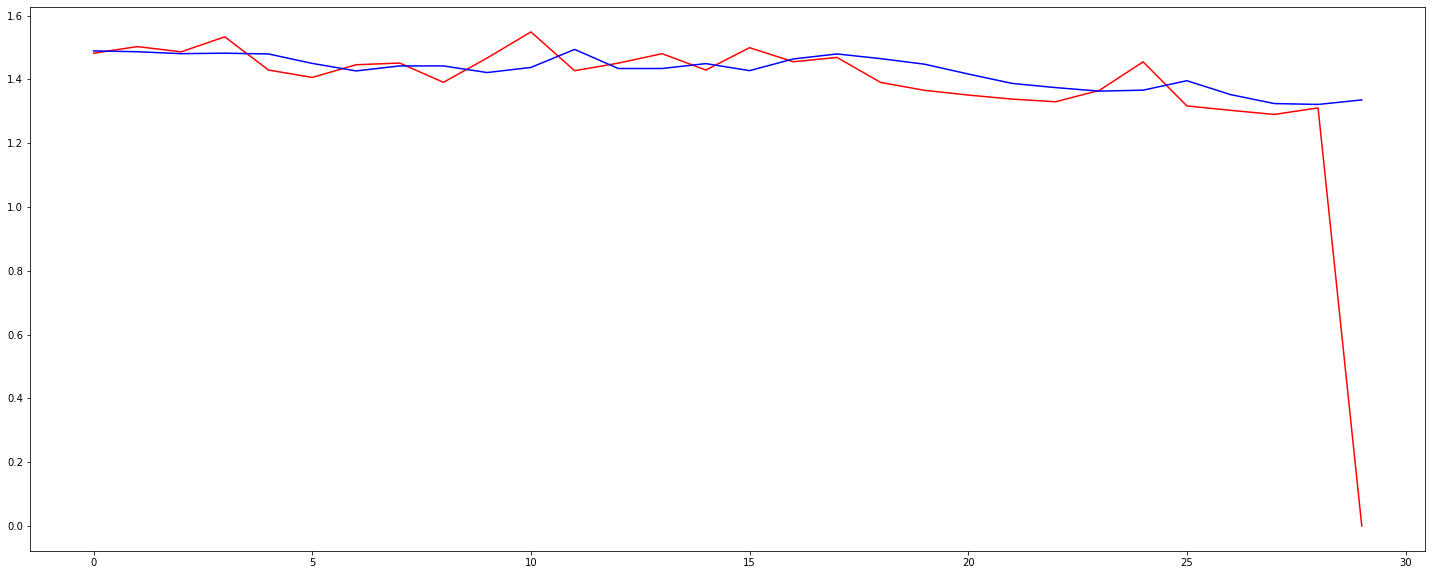

In [204]:
predicted_lstm = pd.DataFrame({'predicted':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()

In [205]:
weather.columns

Index(['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase', 'day'],
      dtype='object')

In [206]:
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')
reframed = series_to_supervised(dataset, 7,1)
reframed.head(10)
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values
# split into train and test sets
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [207]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(train_X, train_y)
Y_pred1 = reg.predict(test_X)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, Y_pred1)
rmse = np.sqrt(mse)
print(rmse)

1.9479922468109843
